<a href="https://colab.research.google.com/github/aderdouri/PINNs/blob/master/poisson_equation_in_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# We solve the 1D Poisson equation:

$$ u''(x) = -f(x), \quad x \in [0, 1] $$
with boundary conditions:
$$ u(0) = 0 \quad \text{and} \quad u(1) = 0. $$For this example, we use $$ f(x) = \sin(\pi x) .$$
The solution is approximated using a Physics-Informed Neural Network (PINN).


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [21]:
# Step 1: Define the PDE
def f(x):
    """Source term f(x)."""
    return torch.sin(np.pi * x)  # Example source term

# Step 2: Define the PINN model
class PINN(nn.Module):
    """Physics-Informed Neural Network."""
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layers = nn.Sequential(
            nn.Linear(1, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.hidden_layers(x)

# Step 3: Define the loss function
def compute_loss(model, x_interior, x_boundary):
    """Compute the combined loss for the PDE residual and boundary conditions."""
    x_interior.requires_grad = True
    u = model(x_interior)
    u_x = torch.autograd.grad(u, x_interior, grad_outputs=torch.ones_like(u),
                              create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_interior, grad_outputs=torch.ones_like(u_x),
                               create_graph=True)[0]

    # PDE residual loss
    f_values = f(x_interior)
    pde_loss = torch.mean((u_xx + f_values) ** 2)

    # Boundary condition loss
    u_boundary = model(x_boundary)
    bc_loss = torch.mean(u_boundary ** 2)

    return pde_loss + bc_loss

# Step 4: Training the model
def train_pinn(model, x_interior, x_boundary, adam_epochs=1000, lbfgs_epochs=500):
    """Train the PINN model using Adam and LBFGS optimizers."""
    # Adam optimizer for initial training
    optimizer_adam = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(adam_epochs):
        optimizer_adam.zero_grad()
        loss = compute_loss(model, x_interior, x_boundary)
        loss.backward()
        optimizer_adam.step()
        if epoch % 100 == 0:
            print(f"Adam Epoch {epoch}, Loss: {loss.item()}")

    # LBFGS optimizer for fine-tuning
    optimizer_lbfgs = torch.optim.LBFGS(model.parameters(),
                                        max_iter=lbfgs_epochs,
                                        tolerance_grad=1e-7,
                                        tolerance_change=1e-9)

    def closure():
        optimizer_lbfgs.zero_grad()
        loss = compute_loss(model, x_interior, x_boundary)
        loss.backward()
        return loss

    print("Starting LBFGS optimization...")
    optimizer_lbfgs.step(closure)

Adam Epoch 0, Loss: 0.2597077488899231
Adam Epoch 100, Loss: 0.0032503020484000444
Adam Epoch 200, Loss: 0.00025865016505122185
Adam Epoch 300, Loss: 0.00011421147792134434
Adam Epoch 400, Loss: 4.168671875959262e-05
Adam Epoch 500, Loss: 1.1409377293603029e-05
Adam Epoch 600, Loss: 3.7778406749566784e-06
Adam Epoch 700, Loss: 2.730507048909203e-06
Adam Epoch 800, Loss: 2.6275613436155254e-06
Adam Epoch 900, Loss: 2.59885428022244e-06
Starting LBFGS optimization...


In [ ]:
# Step 5: Generate training data
x_interior = torch.linspace(0, 1, 100).view(-1, 1)
x_boundary = torch.tensor([[0.0], [1.0]], dtype=torch.float32)

# Step 6: Initialize and train the PINN
model = PINN()
train_pinn(model, x_interior, x_boundary)

In [ ]:
# Step 7: Visualize the solution
x_test = torch.linspace(0, 1, 100).view(-1, 1)
u_pred = model(x_test).detach().numpy()

# Exact solution for comparison
def exact_solution(x):
    return (1 / (np.pi ** 2)) * np.sin(np.pi * x)

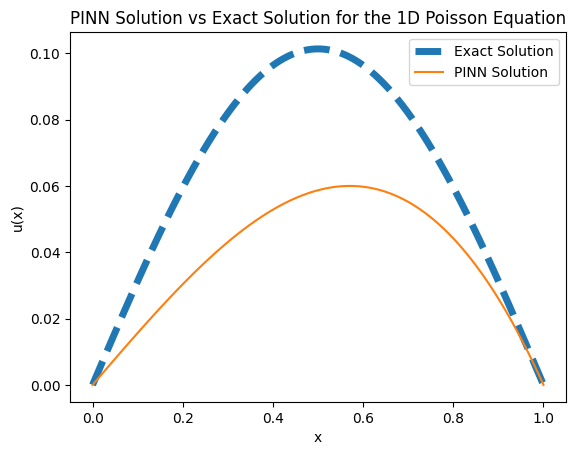

In [22]:
x_exact = x_test.numpy().flatten()
u_exact = exact_solution(x_exact)

plt.plot(x_exact, u_exact, label='Exact Solution', linestyle='dashed', linewidth=5)
plt.plot(x_test.numpy(), u_pred, label='PINN Solution')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('PINN Solution vs Exact Solution for the 1D Poisson Equation')
plt.legend()
plt.show()
